# <center>Xgboost

In [1]:
import os
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta

In [3]:
# import warnings
# warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

In [4]:
data_path = Path("data")
model_path = Path("model_data")

### data

In [5]:
example_predictions_name = "example_predictions.pkl"
test_features_name = "test_features.pkl"
train_features_name = "train_features.pkl"
train_outcomes_name = "train_outcomes.pkl"

In [6]:
test_features = pd.read_pickle(data_path / test_features_name)
train_features = pd.read_pickle(data_path / train_features_name)
train_outcomes = pd.read_pickle(data_path / train_outcomes_name)

In [7]:
test_features.shape, train_features.shape, train_outcomes.shape

((627908, 32), (2106808, 32), (2106808, 1))

In [9]:
from dataprocessing.process import StandardScaler, SmartLogtransformer, TrainTestSplit, Pipeline
from dataprocessing.impute import SimpleImputer

In [10]:
train_test_split = TrainTestSplit(test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_outcomes)

### Pipeline for data processing

In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")), 
        ("logtransformer", SmartLogtransformer()), 
        ("scaler", StandardScaler())
    ]
)
pipe

[(imputer, <dataprocessing.impute.SimpleImputer>), 
(logtransformer, <dataprocessing.process.SmartLogtransformer>), 
(scaler, <dataprocessing.process.StandardScaler>)]

In [12]:
%%time
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(test_features)

Wall time: 5.11 s


## <center>XGBOOST

# <center>Parameter Tuning

In [13]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#### data

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

#### Setting Parameters

In [20]:
param = dict(
    max_depth = 3, 
    eta = 1, 
    objective = 'binary:logistic', 
    eval_metric = 'error'
)

In [16]:
evals = [(dtrain, 'train'), (dval, 'eval')]

#### Training

In [17]:
num_round = 30
bst = xgb.train(param, dtrain, num_round, evals, early_stopping_rounds=3, verbose_eval=False)

In [18]:
bst.save_model(model_path / '0001.model')

In [19]:
bst.best_score

0.414731

In [164]:
bst.best_ntree_limit

12

In [165]:
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [166]:
ypred

array([0.5469042 , 0.5860583 , 0.6249859 , ..., 0.39515105, 0.39515105,
       0.39515105], dtype=float32)

In [167]:
(ypred > 0.5).astype(int)

array([1, 1, 1, ..., 0, 0, 0])

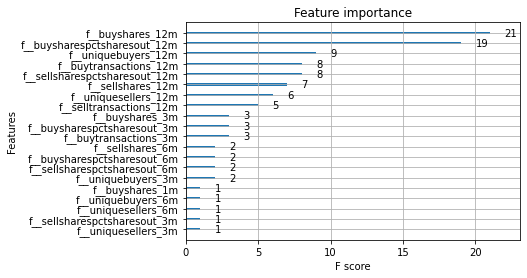

In [168]:
xgb.plot_importance(bst);

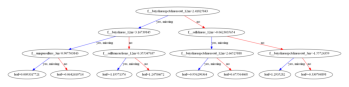

In [169]:
xgb.plot_tree(bst, num_trees=5);

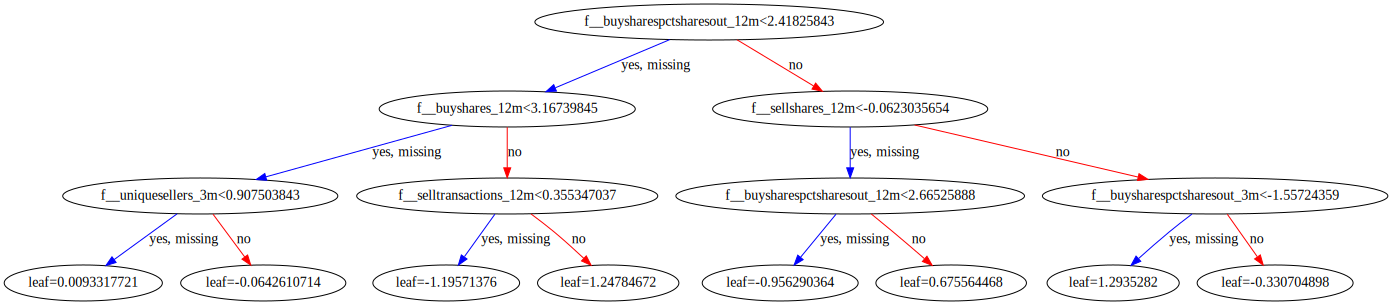

In [170]:
xgb.to_graphviz(bst, num_trees=5)